In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
spec_dir = '../data/train_data/spec/'
with_call = '../data/train_data/spec/1'
without_call = '../data/train_data/spec/0'

paths_with_call = [join(with_call, f) for f in listdir(with_call) if isfile(join(with_call, f))]
paths_without_call = [join(without_call, f) for f in listdir(without_call) if isfile(join(without_call, f))]

- (b) View Batch

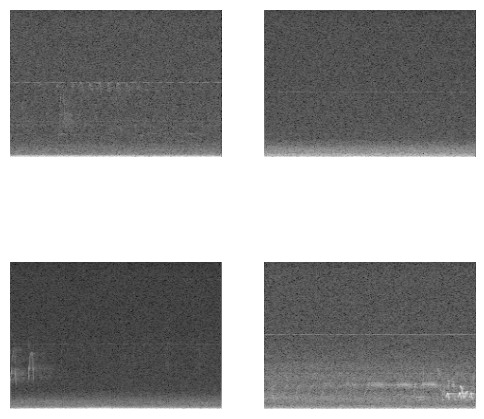

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_with_call[np.random.randint(len(paths_with_call))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_without_call[np.random.randint(len(paths_without_call))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_with_call[np.random.randint(len(paths_with_call))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_without_call[np.random.randint(len(paths_without_call))]));

Define Batch size

In [5]:
batch_size = 16

## B - <a name="generateurs"></a> Data Generators



In [6]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

"""test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   batch_size = batch_size)"""


Found 1164 images belonging to 2 classes.
Found 291 images belonging to 2 classes.


"test_data  = test_data_generator.flow_from_directory(directory = spec_dir,\n                                                   target_size = (224, 224),\n                                                   class_mode = 'binary',\n                                                   batch_size = batch_size)"

In [9]:

print("Class Labels Array:", training_data.samples)
total = training_data.samples
num_pos = np.sum(training_data.classes)
num_neg = total - num_pos

Class Labels Array: 1164


In [10]:
weight_for_0 = (1 / num_neg) * (total / 2.0)
weight_for_1 = (1 / num_pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.8508771929824561, 1: 1.2125}

In [11]:
import pandas as pd
import os

# Get all file paths and their corresponding labels
filepaths = [os.path.join(training_data.directory, fname) for fname in training_data.filenames]
labels = training_data.classes

# Convert to DataFrame
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

Oversample 

In [12]:
from collections import Counter

class_counts = Counter(training_data.classes)
print("Class Distribution:", class_counts)

max_samples = max(Counter(labels).values())  # Find max class count
df_oversampled = df.groupby('label', group_keys=False).apply(lambda x: x.sample(max_samples, replace=True))
df_oversampled.label = df_oversampled.label.astype(str)

print(df_oversampled['label'].value_counts())  # Check new distribution

Class Distribution: Counter({0: 684, 1: 480})
0    684
1    684
Name: label, dtype: int64


In [13]:
training_data_os = data_generator.flow_from_dataframe(
    dataframe=df_oversampled,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=True
)

Found 1368 validated image filenames belonging to 2 classes.


# II - <a name="classif"></a> Classification

- (a) Importer le modèle 

- (b) Instancier un réseau de neurones (appelé ```model```), 

- (c) Compiler le modèle avec une métrique appropriée.

- (d) Entraîner le modèle avec les paramètres de votre choix. On pourra également définir des callbacks.

- (e) Evaluer le modèle sur les données de test avec la méthode ```evaluate```.

In [14]:
# Modèle VGG16
#base_model = VGG16(weights='imagenet', include_top=False)
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches du VGG16
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\dgnhk\AppData\Local\Temp\ipykernel_15124\2462421750.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)


In [15]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 4,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience=3,
                                         factor=0.5,
                                         verbose=2,
                                         mode='min',
                                         min_lr = 1e-10)

In [16]:
optimizer = Adam(learning_rate=0.0001) 

In [17]:
import tensorflow.keras.backend as K

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()  # To avoid log(0) issues
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        
        # Compute binary cross-entropy
        bce = y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred)
        
        # Compute focal loss scaling factor
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = alpha * K.pow(1 - p_t, gamma)
        
        return -K.mean(focal_weight * bce)
    
    return loss

In [18]:
#model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
model.compile(optimizer=optimizer, loss=focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])

In [19]:
history = model.fit(training_data, validation_data=validation_data, epochs=25, 
                    callbacks=[early_stopping,lr_plateau])

Epoch 1/25


c:\Users\dgnhk\anaconda3\envs\yevhenii\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.6073 - loss: 0.0441 - val_accuracy: 0.6735 - val_loss: 0.0374 - learning_rate: 1.0000e-04
Epoch 2/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.7670 - loss: 0.0338 - val_accuracy: 0.7285 - val_loss: 0.0365 - learning_rate: 1.0000e-04
Epoch 3/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.7871 - loss: 0.0308 - val_accuracy: 0.7423 - val_loss: 0.0380 - learning_rate: 1.0000e-04
Epoch 4/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.8065 - loss: 0.0301 - val_accuracy: 0.7423 - val_loss: 0.0374 - learning_rate: 1.0000e-04
Epoch 5/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.8215 - loss: 0.0286 - val_accuracy: 0.7491 - val_loss: 0.0358 - learning_rate: 1.0000e-04
Epoch 6/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.8414 - loss: 0.0265 - val_accuracy: 0.7491 - val_loss: 0.0343 - learning_rate: 1.0000e-04
Epoch 7/25
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.8123 - loss:

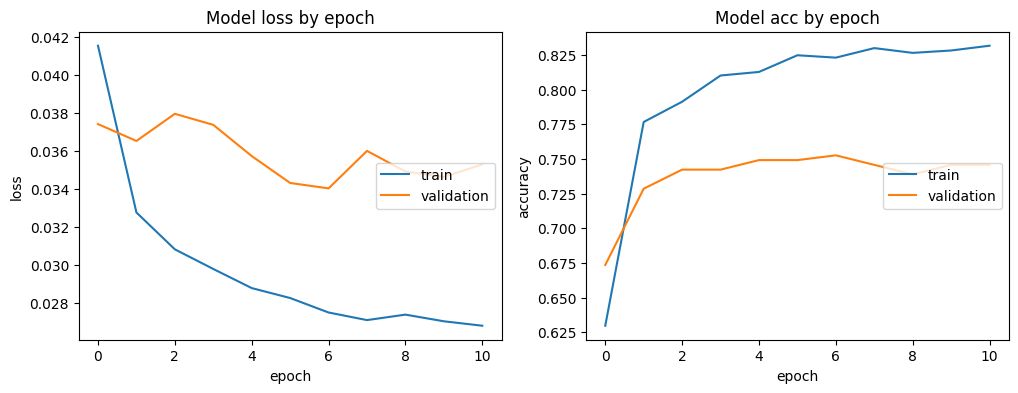

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [21]:
#model.save('../models/my_model_epochs20.h5')

73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step
AP score: 0.4244653191446014


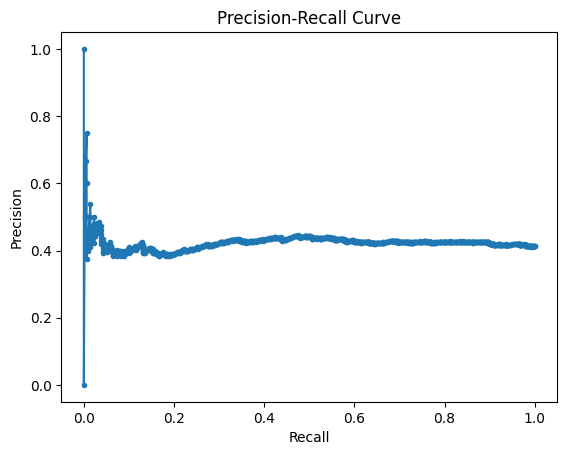

In [22]:
# Get true labels
y_true = training_data.classes  # Ground truth labels

# Get predicted probabilities
y_pred = model.predict(training_data)  # Softmax scores or probability values

ap_score = average_precision_score(y_true, y_pred)
print("AP score:", ap_score)

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Only for binary classification (adjust for multi-class)
precision, recall, _ = precision_recall_curve(y_true, y_pred)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()